In [1]:
import numpy as np
import pandas as pd
from array import array
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
%matplotlib inline
from matplotlib_venn import venn2
import seaborn as sns
import anndata as ad
import phagepy as pp
import scanpy as sc
import scipy.stats as ss
import scipy
import phagepy.analysis as analysis
import re
import os
from collections import Counter
import scipy.stats as stats
from Bio import SeqIO

In [2]:
# define output folder for figures
fig_dir='/data/kortbawi/Chagas/pub/final/final_fig_for_pub/'

In [3]:
# define directory for source and output files
dir='/data/kortbawi/Chagas/pub/final/'

# Read/write

In [4]:
# load processed adata objects
cbm = sc.read_h5ad(dir+'01_cbm.h5ad')
bd = sc.read_h5ad(dir+'01_bd.h5ad')

In [5]:
# load chagas-specific peptide files
chagas_pept_cbm=pd.read_csv(dir+'01_cbm_pept.csv', index_col=0, header=0)
chagas_pept_bd=pd.read_csv(dir+'01_bd_pept.csv', index_col=0, header=0)

# Fig 2c - number of significantly enriched peptides per person

In [6]:
# get list of all enriched peptides in BD specimens - this list will correspond to var_names in adata object
bd_names_all=chagas_pept_bd.sort_values(by='protein',ascending=False).index

# subset adata object for plotting - extract only seropos and seroneg samples, and only peptides enriched in seropos
subset_bd_all = bd[bd.obs['sero'].isin(['seropositive', 'seronegative']), bd_names_all]

# generate df for plotting - will contain sample ids, z-scores, and peptide names
df_bd_all = pd.DataFrame(data=subset_bd_all.layers['z_score'], 
                             index=subset_bd_all.obs.index, 
                             columns=bd_names_all)
df_bd_all = df_bd_all.T

# sort samples by serologic status and by geographic region
sorted_obs = subset_bd_all.obs.sort_values(by=['group', 'region'], ascending=True)
df_bd_all = df_bd_all[sorted_obs.index]

In [7]:
# get list of all enriched peptides in CBM specimens - this list will correspond to var_names in adata object
cbm_names_all=chagas_pept_cbm.sort_values(by='protein',ascending=False).index

# subset adata object for plotting - extract only seropos and seroneg samples, and only peptides enriched in seropos
subset_cbm_all = cbm[cbm.obs['sero'].isin(['seropositive', 'seronegative']), cbm_names_all]

# generate df for plotting - will contain sample ids, z-scores, and peptide names
df_cbm_all = pd.DataFrame(data=subset_cbm_all.layers['z_score'], 
                             index=subset_cbm_all.obs.index, 
                             columns=cbm_names_all)
df_cbm_all = df_cbm_all.T

# sort samples by serologic status and by geographic region
sorted_obs = subset_cbm_all.obs.sort_values(by=['group', 'heart_dz'], ascending=True)
df_cbm_all = df_cbm_all[sorted_obs.index]

In [8]:
# check that subsetted objects have the correct dimensions
subset_bd_all, subset_cbm_all

(View of AnnData object with n_obs × n_vars = 90 × 8710
     obs: 'plate_well', 'BirthReg', 'birth_country', 'sero', 'group', 'region'
     var: 'refseq_id', 'gene', 'protein', 'seq', 'stage'
     obsm: 'DS_z_5'
     layers: 'z_score',
 View of AnnData object with n_obs × n_vars = 228 × 5638
     obs: 'sample_type', 'plate', 'well', 'sample_id', 'rerun', 'group', 'age', 'sex', 'heart_dz', 'sero'
     var: 'refseq_id', 'gene', 'protein', 'seq', 'stage'
     uns: 'control_ids'
     obsm: 'DS_z_5'
     varm: 'X_control'
     layers: 'z_score')

In [9]:
# re-generate ds-specific hits - the obsm of ds-specific hits is not subsetted with the adata object, but z-score data is
# re-generating ds-specific hits using subsetted z-score data will give real counts for just the enriched peptides
def generate_ds_hits_v2(ad, layer, z_cutoff=5):
    """
    Generates Disease-Specific Hits (ds-hits) at a given cutoff (boolean)
    Use this to re-generate DS-specific hits boolean matrix on subsetted adata object that already only contains chagas-specific hits
    Just for plotting!!
    
    Parameters
    ----------
    ad: anndata
    layer: str
        layer parameter (ad.layers[`layer_`]) of anndata object with calculated z-scores based on rpk
    z_cutoff: int, default=5
        if z>z_cutoff, then this a DS-hit for the sample 
    
    Returns
    -------
    None 
    
    Notes
    -----
    Saves DS hits under ad.obsm[`DS_subset_-<z-cutoff>`]
    """
    #take and save DS hits
    ad.obsm['DS_subset_{}'.format(z_cutoff)]=pd.DataFrame(data=ad.layers[layer]>z_cutoff,
                                             index=ad.obs.index,
                                             columns=ad.var.index)
    
    return None

In [10]:
# regenerate DS-hits
subset_cbm_all = subset_cbm_all.copy()
generate_ds_hits_v2(subset_cbm_all, layer='z_score', z_cutoff=5)
subset_cbm_all

AnnData object with n_obs × n_vars = 228 × 5638
    obs: 'sample_type', 'plate', 'well', 'sample_id', 'rerun', 'group', 'age', 'sex', 'heart_dz', 'sero'
    var: 'refseq_id', 'gene', 'protein', 'seq', 'stage'
    uns: 'control_ids'
    obsm: 'DS_z_5', 'DS_subset_5'
    varm: 'X_control'
    layers: 'z_score'

In [11]:
subset_bd_all = subset_bd_all.copy()
generate_ds_hits_v2(subset_bd_all, layer='z_score', z_cutoff=5)
subset_bd_all

AnnData object with n_obs × n_vars = 90 × 8710
    obs: 'plate_well', 'BirthReg', 'birth_country', 'sero', 'group', 'region'
    var: 'refseq_id', 'gene', 'protein', 'seq', 'stage'
    obsm: 'DS_z_5', 'DS_subset_5'
    layers: 'z_score'

In [12]:
subset_cbm_all.obsm['DS_subset_5']=np.array(subset_cbm_all.obsm['DS_subset_5'])
subset_bd_all.obsm['DS_subset_5']=np.array(subset_bd_all.obsm['DS_subset_5'])

In [13]:
# write out subsetted adata object
subset_cbm_all.write_h5ad(dir+'02_cbm_dshits.h5ad')
subset_bd_all.write_h5ad(dir+'02_bd_dshits.h5ad')

In [14]:
# generate table with sum of 'DS_subset_5' and corresponding serpositive/seronegative status and region of origin
index = subset_bd_all.obs_names
group_column = subset_bd_all.obs['sero']
group_column2 = subset_bd_all.obs['region']
sum_column = subset_bd_all.obsm['DS_subset_5'].sum(axis=1)  # sum of ds-hits per-person

bd_numb_pept = pd.DataFrame({
    'Sero': group_column,
    'region': group_column2,
    'z_5_sum': sum_column
}, index=index)
bd_numb_pept.head()

,Sero,region,z_5_sum
tclib_A10_S1196_R1_001,seropositive,SAM,961
tclib_A11_S1197_R1_001,seronegative,Z_UNK,76
tclib_A12_S1198_R1_001,seropositive,Z_UNK,618
tclib_A7_S1193_R1_001,seropositive,Z_UNK,1110
tclib_A8_S1194_R1_001,seronegative,Z_UNK,75


In [15]:
# generate table with sum of 'DS_subset_5' and corresponding serpositive/seronegative status and heart disease status
index = subset_cbm_all.obs_names
group_column = subset_cbm_all.obs['sero']
group2_column = subset_cbm_all.obs['group']
group3_column = subset_cbm_all.obs['heart_dz']
sum_column = subset_cbm_all.obsm['DS_subset_5'].sum(axis=1)

# Create the DataFrame
cbm_numb_pept = pd.DataFrame({
    'Sero': group_column,
    'group': group2_column,
    'heart_dz': group3_column,
    'z_5_sum': sum_column
}, index=index)
cbm_numb_pept.head()

,Sero,group,heart_dz,z_5_sum
CHAGAS_P3A1_BIO_6275-100uL_R1_001-0,seropositive,seropositive,1.0,731
CHAGAS_P3A2_BIO_6304-100uL_R1_001-0,seropositive,seropositive,1.0,456
CHAGAS_P3A3_BIO_6333-100uL_R1_001-0,seropositive,seropositive,1.0,294
CHAGAS_P3A4_BIO_6200-500ul_R1_001-0,seropositive,seropositive,2.0,629
CHAGAS_P3A5_BIO_6286-100ul_R1_001-0,seropositive,seropositive,2.0,629


In [16]:
# merge dfs into one for plotting
merge_numb_pept = pd.concat([cbm_numb_pept, bd_numb_pept])
merge_numb_pept.head()

,Sero,group,heart_dz,z_5_sum,region
CHAGAS_P3A1_BIO_6275-100uL_R1_001-0,seropositive,seropositive,1.0,731,NaN
CHAGAS_P3A2_BIO_6304-100uL_R1_001-0,seropositive,seropositive,1.0,456,NaN
CHAGAS_P3A3_BIO_6333-100uL_R1_001-0,seropositive,seropositive,1.0,294,NaN
CHAGAS_P3A4_BIO_6200-500ul_R1_001-0,seropositive,seropositive,2.0,629,NaN
CHAGAS_P3A5_BIO_6286-100ul_R1_001-0,seropositive,seropositive,2.0,629,NaN


In [17]:
# check that merged df has the right length
merge_numb_pept.shape

(318, 5)

In [18]:
# find median number of per-person peptides of seropositive BD samples
bd_pos_median = bd_numb_pept[bd_numb_pept['Sero'] == 'seropositive']['z_5_sum'].median()
bd_pos_median

np.float64(979.5)

In [19]:
# find median number of per-person peptides of seropositive CBM samples
cbm_pos_median = cbm_numb_pept[cbm_numb_pept['Sero'] == 'seropositive']['z_5_sum'].median()
cbm_pos_median

np.float64(719.0)

In [20]:
# subset BD table into only seropositives to check for differences in number of peptides by region
bd_pos = bd_numb_pept[bd_numb_pept['Sero'] == 'seropositive']
bd_pos.head()

,Sero,region,z_5_sum
tclib_A10_S1196_R1_001,seropositive,SAM,961
tclib_A12_S1198_R1_001,seropositive,Z_UNK,618
tclib_A7_S1193_R1_001,seropositive,Z_UNK,1110
tclib_A9_S1195_R1_001,seropositive,Z_UNK,1122
tclib_B11_S1209_R1_001,seropositive,Z_UNK,1029


In [21]:
# check if there is an association between number of peptides and region
ss.kruskal(bd_pos[bd_pos['region'] == 'MEX']['z_5_sum'],
           bd_pos[bd_pos['region'] == 'SAM']['z_5_sum'],
           bd_pos[bd_pos['region'] == 'CAM']['z_5_sum']
          )

KruskalResult(statistic=np.float64(1.7744200244200243), pvalue=np.float64(0.4118030770545761))

In [22]:
# subset CBM table into only seropositives to check for differences in number of peptides by region
cbm_pos = cbm_numb_pept[cbm_numb_pept['Sero'] == 'seropositive']
cbm_pos.head()

,Sero,group,heart_dz,z_5_sum
CHAGAS_P3A1_BIO_6275-100uL_R1_001-0,seropositive,seropositive,1.0,731
CHAGAS_P3A2_BIO_6304-100uL_R1_001-0,seropositive,seropositive,1.0,456
CHAGAS_P3A3_BIO_6333-100uL_R1_001-0,seropositive,seropositive,1.0,294
CHAGAS_P3A4_BIO_6200-500ul_R1_001-0,seropositive,seropositive,2.0,629
CHAGAS_P3A5_BIO_6286-100ul_R1_001-0,seropositive,seropositive,2.0,629


In [23]:
# check if there is an association between number of peptides and heart disease stage
ss.kruskal(cbm_pos[cbm_pos['heart_dz'] == '1.0']['z_5_sum'],
           cbm_pos[cbm_pos['heart_dz'] == '2.0']['z_5_sum'],
           cbm_pos[cbm_pos['heart_dz'] == '3.0']['z_5_sum'],
           cbm_pos[cbm_pos['heart_dz'] == '4.0']['z_5_sum']
          )

KruskalResult(statistic=np.float64(2.487048184559869), pvalue=np.float64(0.4776363144642619))

In [24]:
# prepare BD table for plotting
## sort samples by region and by ascending number of enriched peptides within each region
bd_numb_pept = bd_numb_pept.sort_values(by=['region', 'z_5_sum'])
## color specimens by region
bd_palette = sns.color_palette("tab10", len(bd_numb_pept['region'].unique()))
bd_numb_pept.head()

,Sero,region,z_5_sum
tclib_C7_S1217_R1_001,seropositive,CAM,572
tclib_E3_S1237_R1_001,seropositive,CAM,810
tclib_F5_S1251_R1_001,seropositive,CAM,862
tclib_H2_S1272_R1_001,seropositive,CAM,987
tclib_E11_S1245_R1_001,seropositive,CAM,1004


In [25]:
# prepare CBM table for plotting
## sort samples by heart disease stage and by ascending number of enriched peptides within each stage
cbm_numb_pept = cbm_numb_pept.sort_values(by=['heart_dz', 'z_5_sum'])
## color specimens by stage
cbm_palette = sns.color_palette("tab20", len(cbm_numb_pept['heart_dz'].unique()))
cbm_numb_pept.head()

,Sero,group,heart_dz,z_5_sum
CHAGAS_P3F8_BIO_6068-500ul_R1_001-0,seronegative,seronegative,1.0,15
CHAGAS_P3C9_BIO_6279-NONE_R1_001-0,seronegative,seronegative,1.0,27
CHAGAS_P3D9_BIO_6283-50ul_R1_001-0,seronegative,seronegative,1.0,29
CHAGAS_P4F8_BIO_6300-NONE_R1_001-0,seronegative,seronegative,1.0,41
CHAGAS_P4H8_BIO_6360-500uL_R1_001-0,seronegative,seronegative,1.0,43


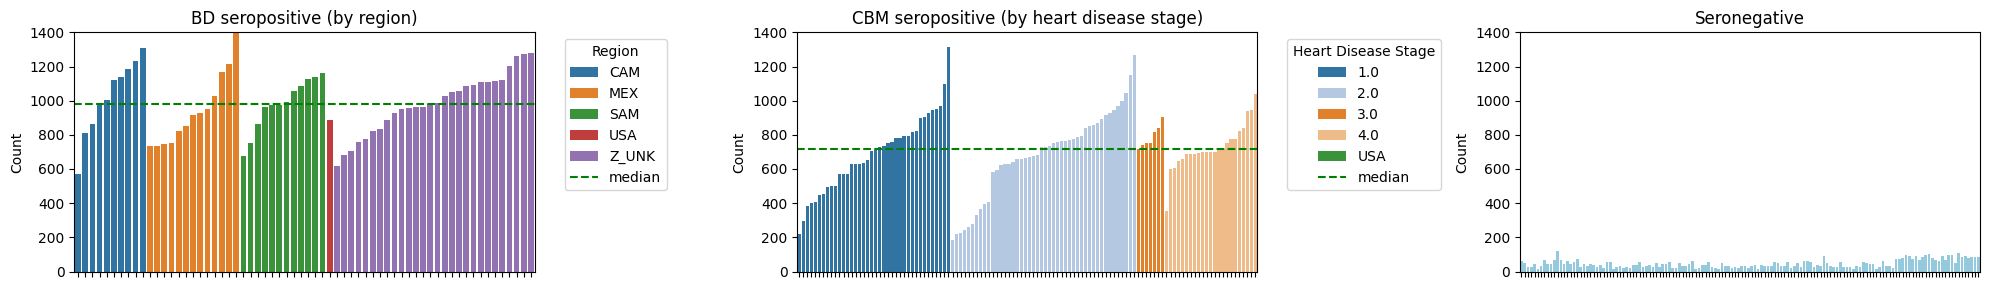

In [26]:
# plot barplot of number of enriched peptides per sample
fig, axes = plt.subplots(1, 3, figsize=(20, 3))

# Plot bd cohort seropositives by region
sns.barplot(data=bd_numb_pept[bd_numb_pept['Sero'] == 'seropositive'], 
            x=bd_numb_pept[bd_numb_pept['Sero'] == 'seropositive'].index, 
            y='z_5_sum', 
            ax=axes[0],
            hue='region',
            palette=bd_palette
           )

axes[0].set_xlabel("")
axes[0].set_xticklabels([])
axes[0].set_ylabel("Count")
axes[0].set_title("BD seropositive (by region)")
axes[0].set_ylim(0, 1400)
axes[0].axhline(bd_pos_median, color='g', linestyle='--', label='median')
axes[0].legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot cbm cohort seropositives by heart disease status
sns.barplot(data=cbm_numb_pept[cbm_numb_pept['Sero'] == 'seropositive'], 
            x=cbm_numb_pept[cbm_numb_pept['Sero'] == 'seropositive'].index, 
            y='z_5_sum', 
            ax=axes[1],  
            hue='heart_dz',
            palette=cbm_palette
           )

axes[1].set_xlabel("")
axes[1].set_xticklabels([])
axes[1].set_ylabel("Count")
axes[1].set_title("CBM seropositive (by heart disease stage)")
axes[1].set_ylim(0,1400)
axes[1].axhline(cbm_pos_median, color='g', linestyle='--', label='median')
axes[1].legend(title='Heart Disease Stage', bbox_to_anchor=(1.05, 1), loc='upper left')

# seronegative plot
sns.barplot(data=merge_numb_pept[merge_numb_pept['Sero'] == 'seronegative'], 
            x=merge_numb_pept[merge_numb_pept['Sero'] == 'seronegative'].index, 
            y='z_5_sum', 
            ax=axes[2],
            color='skyblue'
           )

axes[2].set_xlabel("")
axes[2].set_xticklabels([])
axes[2].set_ylabel("Count")
axes[2].set_title("Seronegative")
axes[2].set_ylim(0,1400)

plt.tight_layout() 
plt.savefig(fig_dir+'fig_2c.pdf', dpi=300 , bbox_inches="tight")
plt.show()